# Time Series Demo: DCorr-X and MGC-X
In this notebook, we demonstrate the cross-distance correlation (`DCorrX`) test and the multiscale graph correlation for time series (`MGCX`) test for independence of time series.

In [3]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import random

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX

**Function to compute and print DCorrX nd MGCX output values, given X and Y:**

In [4]:
def compute_dcorrx(X, Y, max_lag):
    dcorrx = DCorrX(max_lag = max_lag, which_test = 'unbiased')
    dcorrx_statistic, metadata = dcorrx.test_statistic(X, Y)
    p_value, _ = dcorrx.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("DCorrX test statistic:", dcorrx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return dcorrx_statistic, p_value, optimal_lag

def compute_mgcx(X, Y, max_lag, is_fast = False):
    mgcx = MGCX(max_lag = max_lag)
    mgcx_statistic, metadata = mgcx.test_statistic(X, Y, is_fast = is_fast)
    p_value, _ = mgcx.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    
    print("MGCX test statistic:", mgcx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return mgcx_statistic, p_value

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.** In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Function to simulate time series.**

In [5]:
def indep_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are univarite AR(1) with phi = 0.5 for both.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = phi*X[t-1] + epsilons[t]
        Y[t] = phi*Y[t-1] + etas[t]
        
    return X, Y

In [6]:
def lin_dep_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = phi*Y[t-1] + epsilons[t]
        Y[t] = phi*X[t-1] + etas[t]
        
    return X, Y

In [7]:
def nonlin_dep_lag_m(n, m = 1, phi_m = 1, sigma2 = 0.5):
    # X_t and Y_t are together a bivarite nonlinear process.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    for t in range(m):
        Y[t] = etas[t]
    
    # AR(1) process.
    for t in range(m,n):
        X[t] = phi_m*epsilons[t]*Y[t-m]
        Y[t] = etas[t]
        
    return X, Y

**Function to run the Ljung-Box test of dependence using cross-correlations.**

In [8]:
class LJUNG_BOX():
    def __init__(self, max_lag = 0):
        self.max_lag = max_lag
        self.test_stat = None
    def test_statistic(self, X, Y):
        n = len(X)
        test_statistic = 0
        for j in range(self.max_lag+1):
                lead_X = X[j:n]
                lag_Y = Y[0:(n-j)]
                test_statistic += ((np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j))
        self.test_stat = test_statistic*n*(n+2)
        metadata = {}
        return self.test_stat, metadata
    def p_value(self, X, Y, replication_factor = 100):
        test_stat, metadata = self.test_statistic(X, Y)
        pval = 1 - chi2.cdf(test_stat, df = self.max_lag+4)
        metadata = {}
        return pval,  metadata
    def get_test_statistic(self):
        return self.test_stat

**Power as a function of `n` of the tests on each process.** Probability of correctly rejecting the null hypothesis that the time series are independent.

In [9]:
def format_filename(s):
    # Take title and format as filename.
    filename = list(s.lower())
    for i in range(len(filename)):
        if filename[i] == " ":
            filename[i] = "_"
    return(''.join(filename))

In [10]:
def power_curve(sample_sizes, powers, alpha, title, savefig = True):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    
    plt.plot(sample_sizes, powers['dcorrx'], linestyle = '-', color = 'blue')
    # plt.plot(sample_sizes, powers['lb'], linestyle = ':', color = 'red')
    plt.plot(sample_sizes, powers['mgcx'], linestyle = '--', color = 'green')
    ax.legend(['DCorr-X', 'MGC-X'], loc = 'upper left') # Add back LB
    
    ax.axhline(y=alpha, color = 'black', linestyle = '--')
    ax.axhline(y=1, color = 'black', linestyle = '--')
    if savefig:
        filename = "power_curve_%s.png" % format_filename(title)
        plt.savefig(filename)
    plt.show()

**Optimal lag as a function of `n` of the tests on each process.** Probability of detecting the final lag at which there is dependence between the time series, i.e. the window of dependence.

In [11]:
def optimal_lag_curve(sample_sizes, lag_probs, title, savefig = True):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Probability of Detecting Correct Lag")
    
    plt.plot(sample_sizes, lag_probs['dcorrx'], linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, lag_probs['mgcx'], linestyle = '--', color = 'green')
    ax.legend(['Cross-DCorr', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=1, color = 'black', linestyle = '--')
    if savefig:
        filename = "optimal_lag_%s.png" % format_filename(title)
        plt.savefig(filename)
    plt.show()

**Distribution of optimal lags for finite `n`.** The empirical distribution of the optimal lag returned by the test, visualized over the true Pearson's correlation of `X_t` and `Y_t` at each lag.

In [12]:
def opt_lag_dist_stems(optimal_lags, true_correlations, title, color = 'powderblue', savefig = True):
    # True correlations at various lags.
    j = range(true_correlations.shape[0])
    markerline, stemlines, baseline = plt.stem(j, true_correlations, '-k')
    plt.setp(baseline, 'color', 'k', 'linewidth', 1)
    plt.setp(markerline, 'markerfacecolor', 'k')
    plt.xlabel('Lag j')
    plt.ylabel("Corr(X(t), Y(t-j)) / Freq. of Optimal Lag Estimates")
    
    # Optimal lab predictions.
    weights = np.ones_like(optimal_lags)/float(len(optimal_lags))
    plt.hist(optimal_lags, 
             bins = np.arange(len(true_correlations))-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = color)
    
    filename = "optimal_lag_dist_stems_%s.png" % format_filename(title)
    if savefig:
        plt.title(title)
        plt.savefig(filename)
    plt.show()

In [13]:
def opt_lag_dist(optimal_lags, title, color = 'lightgreen', savefig = True):
    # True correlations at various lags.
    plt.xlabel('Lag j')
    plt.ylabel("Freq. of Optimal Lag Estimates")
    
    # Optimal lab predictions.
    weights = np.ones_like(optimal_lags)/float(len(optimal_lags))
    plt.hist(optimal_lags, 
             bins = np.arange(len(true_correlations))-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = color)
    
    filename = "optimal_lag_dist_%s.png" % format_filename(title)
    if savefig:
        plt.title(title)
        plt.savefig(filename)
    plt.show()

**Full experiment, simulating the above time series, and counting the rejections and optimal lag detections by each test (as a function of `n`).**

In [14]:
# Combining all time series simulations.
processes = {
    'indep_ar1'  : { 'simulate': indep_ar1,  'name': "Independent AR(1)", 'true_lag': -1},
    'lin_dep_ar1': { 'simulate': lin_dep_ar1,  'name': "Correlated AR(1)", 'true_lag': 1},
    'nonlin_dep_lag_m' : { 'simulate': nonlin_dep_lag_m,  'name': "Nonlinearly Dependent at Lag 1", 'true_lag': 1}, 
}

In [15]:
# Experiment 1: parameters.
sample_sizes  = range(10,100,10)
num_sims      = 100
num_bootstrap = 100
alpha         = 0.05
maxlag        = 1
compute_pval  = True

Estimating power/lag detection prob. at n = 10....................................................................................................
Estimating power/lag detection prob. at n = 20....................................................................................................
Estimating power/lag detection prob. at n = 30....................................................................................................
Estimating power/lag detection prob. at n = 40....................................................................................................
Estimating power/lag detection prob. at n = 50....................................................................................................
Estimating power/lag detection prob. at n = 60....................................................................................................
Estimating power/lag detection prob. at n = 70........................................................................

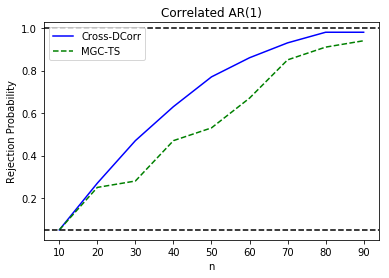

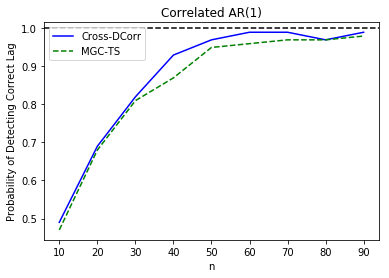

In [13]:
# Initialize objects and holders.
random.seed(123)
dcorrx      = DCorrX(max_lag = maxlag)
mgcx    = MGCX(max_lag = maxlag)
lb        = LJUNG_BOX(max_lag = maxlag)
tests     = {'dcorrx': dcorrx, 'mgcx': mgcx, 'lb': lb}
powers    = {'dcorrx': np.zeros(len(sample_sizes)), 
             'mgcx': np.zeros(len(sample_sizes)), 
             'lb': np.zeros(len(sample_sizes))}
lag_probs = {'dcorrx': np.zeros(len(sample_sizes)), 
             'mgcx': np.zeros(len(sample_sizes))}

# Run experiments.
for p in ['lin_dep_ar1']:
    process = processes[p]
    simulate = process['simulate']
    for i in range(len(sample_sizes)):
        rejects  = {'dcorrx': 0.0, 'mgcx': 0.0, 'lb': 0.0}
        opt_lags = {'dcorrx': np.zeros(num_sims), 'mgcx': np.zeros(num_sims)}
        n = sample_sizes[i]
        print("Estimating power/lag detection prob. at n =", str(n), end = "")
        
        # Simulate time series and count rejections.
        for t in range(num_sims):
            print('.', end='')
            X, Y = simulate(n)
            
            for r in ['dcorrx', 'mgcx', 'lb']:
                test = tests[r]
                if r is not 'lb':
                    test_statistic, metadata = test.test_statistic(X, Y)
                    detects = opt_lags[r]
                    detects[t] = metadata['optimal_lag']
                if compute_pval:
                    p_value, _ = test.p_value(X, Y, replication_factor = num_bootstrap)
                    if (p_value < alpha): rejects[r] += 1
        for r in ['dcorrx', 'mgcx', 'lb']: 
            power = powers[r]
            power[i] = rejects[r]/num_sims
            if r is not 'lb':
                lag_prob = lag_probs[r]
                lag_prob[i] = np.count_nonzero(opt_lags[r] == process['true_lag'])/num_sims
        print("")
        
    # Display power estimates and probility of detecting the correct lag.
    if compute_pval:
        power_curve(sample_sizes, powers, alpha, process['name'])
    optimal_lag_curve(sample_sizes, lag_probs, process['name'])

In [14]:
# Experiment 2: parameters.
sample_sizes  = range(10,185,20)
num_sims      = 100
num_bootstrap = 100
alpha         = 0.05
maxlag        = 1
compute_pval  = True

Estimating power/lag detection prob. at n = 10....................................................................................................
Estimating power/lag detection prob. at n = 30....................................................................................................
Estimating power/lag detection prob. at n = 50....................................................................................................
Estimating power/lag detection prob. at n = 70....................................................................................................
Estimating power/lag detection prob. at n = 90....................................................................................................
Estimating power/lag detection prob. at n = 110....................................................................................................
Estimating power/lag detection prob. at n = 130......................................................................

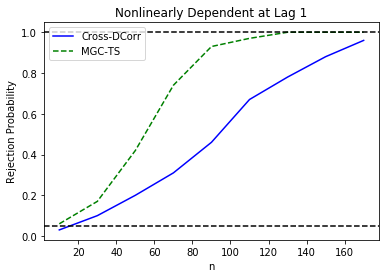

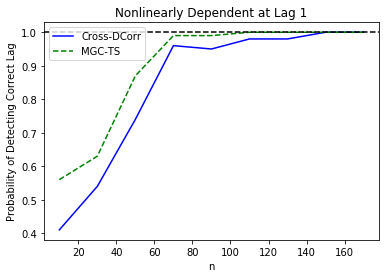

In [15]:
# Initialize objects and holders.
dcorrx  = DCorrX(max_lag = maxlag)
mgcx    = MGCX(max_lag = maxlag)
lb      = LJUNG_BOX(max_lag = maxlag)
tests   = {'dcorrx': dcorrx, 'mgcx': mgcx, 'lb': lb}
powers  = {'dcorrx': np.zeros(len(sample_sizes)), 
           'mgcx': np.zeros(len(sample_sizes)), 
           'lb': np.zeros(len(sample_sizes))}
lag_probs = {'dcorrx': np.zeros(len(sample_sizes)), 
             'mgcx': np.zeros(len(sample_sizes))}

# Run experiments.
for p in ['nonlin_dep_lag_m']:
    process = processes[p]
    simulate = process['simulate']
    for i in range(len(sample_sizes)):
        rejects  = {'dcorrx': 0.0, 'mgcx': 0.0, 'lb': 0.0}
        opt_lags = {'dcorrx': np.zeros(num_sims), 'mgcx': np.zeros(num_sims)}
        n = sample_sizes[i]
        print("Estimating power/lag detection prob. at n =", str(n), end = "")
        
        # Simulate time series and count rejections.
        for t in range(num_sims):
            print('.', end='')
            X, Y = simulate(n)
            
            for r in ['dcorrx', 'mgcx']:
                test = tests[r]
                if r is not 'lb':
                    test_statistic, metadata = test.test_statistic(X, Y)
                    detects = opt_lags[r]
                    detects[t] = metadata['optimal_lag']
                if compute_pval:
                    p_value, _ = test.p_value(X, Y, replication_factor = num_bootstrap)
                    if (p_value < alpha): rejects[r] += 1
        for r in ['dcorrx', 'mgcx']:
            power = powers[r]
            power[i] = rejects[r]/num_sims
            if r is not 'lb':
                lag_prob = lag_probs[r]
                lag_prob[i] = np.count_nonzero(opt_lags[r] == process['true_lag'])/num_sims
        print("")
        
    # Display power estimates and probility of detecting the correct lag.
    if compute_pval:
        power_curve(sample_sizes, powers, alpha, process['name'])
    optimal_lag_curve(sample_sizes, lag_probs, process['name'])

**Analyzing the distribution of optimal lags returned by the tests.** We see how that the optimal lags returned by the test corresponds with the true dependence structure of the simulated time series.

In [16]:
def lin_dep_ar3(n, phi_1 = 0.5, phi_3 = 0.5, sigma2 = 1.0):
    # X_t and Y_t are together a bivarite AR(3).
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    for s in range(3):
        X[s] = epsilons[s]
        Y[s] = etas[s]
    
    # AR(1) process.
    for t in range(3,n):
        X[t] = phi_1*Y[t-1] + phi_3*Y[t-3] + epsilons[t]
        Y[t] = phi_1*X[t-1] + phi_3*X[t-3] + etas[t]
        
    return X, Y

In [ ]:
# Correlated AR(3)
phi_1 = 0.8
phi_3 = 0.1
sigma2 = 1.0
M = 10
num_sims = 100

# Determine true correlations.
rho_XY = np.zeros(M+1)
rho_X = np.zeros(M+1)
rho_X[0] = 1
rho_XY[1] = phi_1 / (1 - phi_3*(phi_1 + phi_3))
rho_X[2] = (phi_1 + phi_3)*rho_XY[1]
for j in range(3, M+1):
    if j%2:
        rho_XY[j] = phi_1*rho_X[j-1] + phi_3*rho_X[j-3]
    else:
        rho_X[j] = phi_1*rho_XY[j-1] + phi_3*rho_XY[j-3]

dcorrx = DCorrX(max_lag = M)
mgcx = MGCX(max_lag = M)
true_correlations = rho_XY
optimal_lags_dcorrx = np.zeros(num_sims)
optimal_lags_mgcx = np.zeros(num_sims)

# Run experiments.
for n in [15, 30, 60]:
    for t in range(num_sims):
        X, Y = lin_dep_ar3(n, phi_1 = phi_1, phi_3 = phi_3, sigma2 = sigma2)
        test_statistic, metadata = dcorrx.test_statistic(X, Y)
        optimal_lags_dcorrx[t] = metadata['optimal_lag']
        test_statistic, metadata = mgcx.test_statistic(X, Y)
        optimal_lags_mgcx[t] = metadata['optimal_lag']
    title_dcorrx = "Dcorr-X, Crosscorrelated AR(3), n = %d" % n
    title_mgcx = "MGC-X, Crosscorrelated AR(3), n = %d" % n
    opt_lag_dist_stems(optimal_lags_dcorrx, true_correlations, title = title_dcorrx, color = 'powderblue')
    opt_lag_dist_stems(optimal_lags_mgcx, true_correlations, title = title_mgcx, color = 'lightgreen')

**Simulate a nonlinear process, estimate the Cross Distance Correlation Function, and show that the optimal lag is correct for large n.**

In [ ]:
sigma2 = 1.0
M = 10
m = 3
num_sims = 100

dcorrx = DCorrX(max_lag = M)
mgcx = MGCX(max_lag = M)
optimal_lags_dcorrx = np.zeros(num_sims)
optimal_lags_mgcx = np.zeros(num_sims)

# Run experiments.
for n in [25, 50, 100]:
    for t in range(num_sims):
        X, Y = nonlin_dep_lag_m(n, m, phi_m = 0.8, sigma2 = 1.0)
        test_statistic, metadata = dcorrx.test_statistic(X, Y)
        optimal_lags_dcorrx[t] = metadata['optimal_lag']
        test_statistic, metadata = mgcx.test_statistic(X, Y)
        optimal_lags_mgcx[t] = metadata['optimal_lag']
    title_dcorrx = "Dcorr-X, Nonlinearly Dependent at Lag 3, n = %d" % n
    title_mgcx = "MGC-X, Nonlinearly Dependent at Lag 3, n = %d" % n
    opt_lag_dist(optimal_lags_dcorrx, title = title_dcorrx, color = 'powderblue')
    opt_lag_dist(optimal_lags_mgcx, title = title_mgcx, color = 'lightgreen')